In [15]:
import spatialdata
import skimage.io as io
import numpy as np
import opendvp
import pandas as pd
import anndata as ad
import geopandas as gpd
from shapely import Polygon
import ast
from typing import Sequence

import anndata as ad
import geopandas as gpd
import numpy as np
import pandas as pd

from opendvp.utils import logger

In [10]:
n_obs = 100
obs_data = pd.DataFrame({
    "CellID": [f"cell_{i}" for i in range(n_obs)],
    "X_centroid": np.random.rand(n_obs) * 100,
    "Y_centroid": np.random.rand(n_obs) * 100,
    "custom_x": np.random.rand(n_obs) * 100,
    "custom_y": np.random.rand(n_obs) * 100, # Removed .set_index("CellID")
})
adata = ad.AnnData(obs=obs_data)

# Create two polygons with classification
polygon1 = Polygon([(0, 0), (0, 50), (50, 50), (50, 0)])
polygon2 = Polygon([(60, 60), (60, 100), (100, 100), (100, 60)])
gdf = gpd.GeoDataFrame({
    "geometry": [polygon1, polygon2],
    "classification": ['{"name": "ClassA"}', '{"name": "ClassB"}']
}, crs="EPSG:4326")

/opt/homebrew/Caskroom/mambaforge/base/envs/opendvp-sdata/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
adata.obs

,CellID,X_centroid,Y_centroid,custom_x,custom_y
0,cell_0,96.517074,5.260082,42.144604,16.772186
1,cell_1,86.388183,65.092917,58.829776,72.890341
2,cell_2,94.706383,38.288851,88.507747,83.934768
3,cell_3,27.891581,87.828370,59.886912,3.578133
4,cell_4,66.044906,42.243968,28.310947,64.784422
...,...,...,...,...,...
95,cell_95,7.099175,97.538669,80.568819,91.323532
96,cell_96,46.918371,83.957661,23.536948,84.621386
97,cell_97,31.910790,89.549749,4.971728,73.573001
98,cell_98,68.130379,81.456729,8.822847,67.723706


In [13]:
gdf

,geometry,classification
0,"POLYGON ((0 0, 0 50, 50 50, 50 0, 0 0))","{""name"": ""ClassA""}"
1,"POLYGON ((60 60, 60 100, 100 100, 100 60, 60 60))","{""name"": ""ClassB""}"


In [14]:
adata_copy = adata.copy()

In [16]:
gdf['class_name'] = gdf['classification'].apply(
        lambda x: ast.literal_eval(x).get('name') if isinstance(x, str) else x.get('name')
    )
gdf

,geometry,classification,class_name
0,"POLYGON ((0 0, 0 50, 50 50, 50 0, 0 0))","{""name"": ""ClassA""}",ClassA
1,"POLYGON ((60 60, 60 100, 100 100, 100 60, 60 60))","{""name"": ""ClassB""}",ClassB


In [17]:
all_geojson_classes = gdf['class_name'].dropna().unique().tolist()
all_geojson_classes

['ClassA', 'ClassB']

In [19]:
x_y = ["X_centroid", "Y_centroid"]
cell_id_col = "CellID"
# Check required columns in adata.obs
required_cols = list(x_y) + [cell_id_col]
missing_cols = [col for col in required_cols if col not in adata.obs.columns]
if missing_cols: # Check against original adata.obs for missing columns
    raise ValueError(f"Required column(s) missing from adata.obs: {', '.join(missing_cols)}")

In [20]:
adata.obs

,CellID,X_centroid,Y_centroid,custom_x,custom_y
0,cell_0,96.517074,5.260082,42.144604,16.772186
1,cell_1,86.388183,65.092917,58.829776,72.890341
2,cell_2,94.706383,38.288851,88.507747,83.934768
3,cell_3,27.891581,87.828370,59.886912,3.578133
4,cell_4,66.044906,42.243968,28.310947,64.784422
...,...,...,...,...,...
95,cell_95,7.099175,97.538669,80.568819,91.323532
96,cell_96,46.918371,83.957661,23.536948,84.621386
97,cell_97,31.910790,89.549749,4.971728,73.573001
98,cell_98,68.130379,81.456729,8.822847,67.723706


In [21]:
 # Convert AnnData cell centroids to a GeoDataFrame
points_gdf = gpd.GeoDataFrame(
    adata_copy.obs, geometry=gpd.points_from_xy(adata_copy.obs[x_y[0]], adata_copy.obs[x_y[1]]), crs=gdf.crs
) 
points_gdf

,CellID,X_centroid,Y_centroid,custom_x,custom_y,geometry
0,cell_0,96.517074,5.260082,42.144604,16.772186,POINT (96.51707 5.26008)
1,cell_1,86.388183,65.092917,58.829776,72.890341,POINT (86.38818 65.09292)
2,cell_2,94.706383,38.288851,88.507747,83.934768,POINT (94.70638 38.28885)
3,cell_3,27.891581,87.828370,59.886912,3.578133,POINT (27.89158 87.82837)
4,cell_4,66.044906,42.243968,28.310947,64.784422,POINT (66.04491 42.24397)
...,...,...,...,...,...,...
95,cell_95,7.099175,97.538669,80.568819,91.323532,POINT (7.09917 97.53867)
96,cell_96,46.918371,83.957661,23.536948,84.621386,POINT (46.91837 83.95766)
97,cell_97,31.910790,89.549749,4.971728,73.573001,POINT (31.91079 89.54975)
98,cell_98,68.130379,81.456729,8.822847,67.723706,POINT (68.13038 81.45673)


In [22]:
# Perform spatial join: find which points fall within which polygons
joined = gpd.sjoin(points_gdf, gdf[['geometry', 'class_name']], how='left', predicate='within')
joined

,CellID,X_centroid,Y_centroid,custom_x,custom_y,geometry,index_right,class_name
0,cell_0,96.517074,5.260082,42.144604,16.772186,POINT (96.51707 5.26008),NaN,NaN
1,cell_1,86.388183,65.092917,58.829776,72.890341,POINT (86.38818 65.09292),1.0,ClassB
2,cell_2,94.706383,38.288851,88.507747,83.934768,POINT (94.70638 38.28885),NaN,NaN
3,cell_3,27.891581,87.828370,59.886912,3.578133,POINT (27.89158 87.82837),NaN,NaN
4,cell_4,66.044906,42.243968,28.310947,64.784422,POINT (66.04491 42.24397),NaN,NaN
...,...,...,...,...,...,...,...,...
95,cell_95,7.099175,97.538669,80.568819,91.323532,POINT (7.09917 97.53867),NaN,NaN
96,cell_96,46.918371,83.957661,23.536948,84.621386,POINT (46.91837 83.95766),NaN,NaN
97,cell_97,31.910790,89.549749,4.971728,73.573001,POINT (31.91079 89.54975),NaN,NaN
98,cell_98,68.130379,81.456729,8.822847,67.723706,POINT (68.13038 81.45673),1.0,ClassB


In [23]:
joined.class_name.unique()

array([nan, 'ClassB', 'ClassA'], dtype=object)

In [25]:
joined[joined.class_name.notna()]

,CellID,X_centroid,Y_centroid,custom_x,custom_y,geometry,index_right,class_name
1,cell_1,86.388183,65.092917,58.829776,72.890341,POINT (86.38818 65.09292),1.0,ClassB
6,cell_6,87.322979,66.468499,15.013990,4.399271,POINT (87.32298 66.4685),1.0,ClassB
7,cell_7,34.788837,42.150279,92.907477,88.453927,POINT (34.78884 42.15028),0.0,ClassA
9,cell_9,1.572554,18.516977,65.567034,87.772519,POINT (1.57255 18.51698),0.0,ClassA
11,cell_11,9.722274,27.270517,36.953384,78.470601,POINT (9.72227 27.27052),0.0,ClassA
13,cell_13,15.391783,17.352602,77.886396,45.043095,POINT (15.39178 17.3526),0.0,ClassA
14,cell_14,25.395105,44.111082,8.929815,11.858587,POINT (25.3951 44.11108),0.0,ClassA
15,cell_15,4.172040,18.788168,71.338220,74.391476,POINT (4.17204 18.78817),0.0,ClassA
16,cell_16,41.150001,40.798234,74.888841,73.894251,POINT (41.15 40.79823),0.0,ClassA
20,cell_20,91.244609,86.186581,71.744480,19.959306,POINT (91.24461 86.18658),1.0,ClassB


In [24]:
annotation_dummies = pd.get_dummies(
        joined[[cell_id_col, 'class_name']], columns=['class_name'], prefix='', prefix_sep='')
annotation_dummies

,CellID,ClassA,ClassB
0,cell_0,False,False
1,cell_1,False,True
2,cell_2,False,False
3,cell_3,False,False
4,cell_4,False,False
...,...,...,...
95,cell_95,False,False
96,cell_96,False,False
97,cell_97,False,False
98,cell_98,False,True


In [26]:
# Group by cell_id_col and take max to handle multiple annotations for a single cell
annotation_presence = annotation_dummies.groupby(cell_id_col).max()
annotation_presence

,ClassA,ClassB
CellID,,
cell_0,False,False
cell_1,False,True
cell_10,False,False
cell_11,True,False
cell_12,False,False
...,...,...
cell_95,False,False
cell_96,False,False
cell_97,False,False


In [27]:
actual_annotation_cols = all_geojson_classes # These are the columns representing actual annotation classes
actual_annotation_cols

['ClassA', 'ClassB']

In [28]:
any_label = "ANY"
annotation_presence[any_label] = annotation_presence[actual_annotation_cols].any(axis=1)
annotation_presence

,ClassA,ClassB,ANY
CellID,,,
cell_0,False,False,False
cell_1,False,True,True
cell_10,False,False,False
cell_11,True,False,True
cell_12,False,False,False
...,...,...,...
cell_95,False,False,False
cell_96,False,False,False
cell_97,False,False,False


In [29]:
annotation_presence['annotation'] = annotation_presence[actual_annotation_cols].apply(
        lambda row: next((col for col in actual_annotation_cols if row[col]), 'Unannotated'), axis=1
    )
annotation_presence

,ClassA,ClassB,ANY,annotation
CellID,,,,
cell_0,False,False,False,Unannotated
cell_1,False,True,True,ClassB
cell_10,False,False,False,Unannotated
cell_11,True,False,True,ClassA
cell_12,False,False,False,Unannotated
...,...,...,...,...
cell_95,False,False,False,Unannotated
cell_96,False,False,False,Unannotated
cell_97,False,False,False,Unannotated


In [30]:
# 4. Merge the new annotation columns back into adata.obs
adata_copy.obs = adata_copy.obs.merge(annotation_presence.reset_index(), on=cell_id_col, how='left')
adata_copy.obs

,CellID,X_centroid,Y_centroid,custom_x,custom_y,ClassA,ClassB,ANY,annotation
0,cell_0,96.517074,5.260082,42.144604,16.772186,False,False,False,Unannotated
1,cell_1,86.388183,65.092917,58.829776,72.890341,False,True,True,ClassB
2,cell_2,94.706383,38.288851,88.507747,83.934768,False,False,False,Unannotated
3,cell_3,27.891581,87.828370,59.886912,3.578133,False,False,False,Unannotated
4,cell_4,66.044906,42.243968,28.310947,64.784422,False,False,False,Unannotated
...,...,...,...,...,...,...,...,...,...
95,cell_95,7.099175,97.538669,80.568819,91.323532,False,False,False,Unannotated
96,cell_96,46.918371,83.957661,23.536948,84.621386,False,False,False,Unannotated
97,cell_97,31.910790,89.549749,4.971728,73.573001,False,False,False,Unannotated
98,cell_98,68.130379,81.456729,8.822847,67.723706,False,True,True,ClassB


In [31]:
# Fill any NaNs introduced by the merge (for cells that had no spatial annotation)
for col in actual_annotation_cols + [any_label]: # Apply fillna to all relevant boolean columns
    adata_copy.obs[col] = adata_copy.obs[col].fillna(False)
adata_copy.obs['annotation'] = adata_copy.obs['annotation'].fillna('Unannotated')
adata_copy.obs

,CellID,X_centroid,Y_centroid,custom_x,custom_y,ClassA,ClassB,ANY,annotation
0,cell_0,96.517074,5.260082,42.144604,16.772186,False,False,False,Unannotated
1,cell_1,86.388183,65.092917,58.829776,72.890341,False,True,True,ClassB
2,cell_2,94.706383,38.288851,88.507747,83.934768,False,False,False,Unannotated
3,cell_3,27.891581,87.828370,59.886912,3.578133,False,False,False,Unannotated
4,cell_4,66.044906,42.243968,28.310947,64.784422,False,False,False,Unannotated
...,...,...,...,...,...,...,...,...,...
95,cell_95,7.099175,97.538669,80.568819,91.323532,False,False,False,Unannotated
96,cell_96,46.918371,83.957661,23.536948,84.621386,False,False,False,Unannotated
97,cell_97,31.910790,89.549749,4.971728,73.573001,False,False,False,Unannotated
98,cell_98,68.130379,81.456729,8.822847,67.723706,False,True,True,ClassB


In [58]:
"""Create a sample AnnData object for testing."""
# Create deterministic coordinates for cells
coords = {
    "in_A_only": (10, 10),
    "in_B_only": (90, 90),
    "in_C_only": (10, 90),
    "in_A_and_B_overlap": (60, 60), # In the overlap of A and B
    "unannotated": (150, 150)
}

obs_data = pd.DataFrame({
    "CellID": list(coords.keys()),
    "X_centroid": [c[0] for c in coords.values()],
    "Y_centroid": [c[1] for c in coords.values()],
    "custom_x": [c[0] for c in coords.values()],
    "custom_y": [c[1] for c in coords.values()],
})

adata = ad.AnnData(obs=obs_data)

/opt/homebrew/Caskroom/mambaforge/base/envs/opendvp-sdata/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [36]:
adata.obs

,CellID,X_centroid,Y_centroid,custom_x,custom_y
0,in_A_only,10,10,10,10
1,in_B_only,90,90,90,90
2,in_C_only,10,90,10,90
3,in_A_and_B_overlap,60,60,60,60
4,unannotated,150,150,150,150


In [59]:
adata_copy = adata.copy()

In [43]:
"""Create a sample GeoDataFrame representing a GeoJSON file."""
# Create two polygons with classification
polygon1 = Polygon([(0, 0), (0, 70), (70, 70), (70, 0)]) # ClassA
polygon2 = Polygon([(50, 50), (50, 120), (120, 120), (120, 50)]) # ClassB, overlaps with A
polygon3 = Polygon([(0, 80), (0, 120), (40, 120), (40, 80)]) # ClassC, no overlap
gdf = gpd.GeoDataFrame({
    "geometry": [polygon1, polygon2, polygon3],
    "classification": ['{"name": "ClassA"}', '{"name": "ClassB"}', '{"name": "ClassC"}']
}, crs="EPSG:4326")

In [45]:
gdf

,geometry,classification
0,"POLYGON ((0 0, 0 70, 70 70, 70 0, 0 0))","{""name"": ""ClassA""}"
1,"POLYGON ((50 50, 50 120, 120 120, 120 50, 50 50))","{""name"": ""ClassB""}"
2,"POLYGON ((0 80, 0 120, 40 120, 40 80, 0 80))","{""name"": ""ClassC""}"


In [47]:
gdf['class_name'] = gdf['classification'].apply(
        lambda x: ast.literal_eval(x).get('name') if isinstance(x, str) else x.get('name')
    )
gdf

,geometry,classification,class_name
0,"POLYGON ((0 0, 0 70, 70 70, 70 0, 0 0))","{""name"": ""ClassA""}",ClassA
1,"POLYGON ((50 50, 50 120, 120 120, 120 50, 50 50))","{""name"": ""ClassB""}",ClassB
2,"POLYGON ((0 80, 0 120, 40 120, 40 80, 0 80))","{""name"": ""ClassC""}",ClassC


In [49]:
gdf

,geometry,classification,class_name
0,"POLYGON ((0 0, 0 70, 70 70, 70 0, 0 0))","{""name"": ""ClassA""}",ClassA
1,"POLYGON ((50 50, 50 120, 120 120, 120 50, 50 50))","{""name"": ""ClassB""}",ClassB
2,"POLYGON ((0 80, 0 120, 40 120, 40 80, 0 80))","{""name"": ""ClassC""}",ClassC


<Axes: xlabel='X_centroid', ylabel='Y_centroid'>

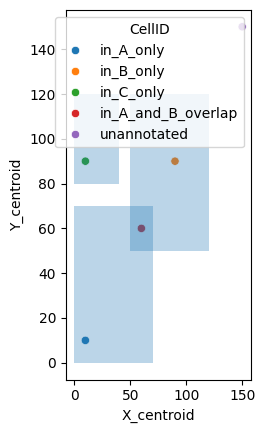

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
sns.scatterplot(data=adata.obs, x="X_centroid", y="Y_centroid", hue="CellID", ax=ax)
gdf.plot(ax=ax, alpha=0.3)

In [71]:
all_geojson_classes = gdf['class_name'].dropna().unique().tolist()
all_geojson_classes

['ClassA', 'ClassB', 'ClassC']

In [56]:
required_cols = list(x_y) + [cell_id_col]
missing_cols = [col for col in required_cols if col not in adata.obs.columns]
if missing_cols:
    raise ValueError(f"Required column(s) missing from adata.obs: {', '.join(missing_cols)}")

In [60]:
# Convert AnnData cell centroids to a GeoDataFrame
points_gdf = gpd.GeoDataFrame(
    adata_copy.obs, geometry=gpd.points_from_xy(adata_copy.obs[x_y[0]], adata_copy.obs[x_y[1]]), crs=gdf.crs
)   
points_gdf

,CellID,X_centroid,Y_centroid,custom_x,custom_y,geometry
0,in_A_only,10,10,10,10,POINT (10 10)
1,in_B_only,90,90,90,90,POINT (90 90)
2,in_C_only,10,90,10,90,POINT (10 90)
3,in_A_and_B_overlap,60,60,60,60,POINT (60 60)
4,unannotated,150,150,150,150,POINT (150 150)


In [62]:
# Perform spatial join: find which points fall within which polygons
joined = gpd.sjoin(points_gdf, gdf[['geometry', 'class_name']], how='left', predicate='within')
joined

,CellID,X_centroid,Y_centroid,custom_x,custom_y,geometry,index_right,class_name
0,in_A_only,10,10,10,10,POINT (10 10),0.0,ClassA
1,in_B_only,90,90,90,90,POINT (90 90),1.0,ClassB
2,in_C_only,10,90,10,90,POINT (10 90),2.0,ClassC
3,in_A_and_B_overlap,60,60,60,60,POINT (60 60),0.0,ClassA
3,in_A_and_B_overlap,60,60,60,60,POINT (60 60),1.0,ClassB
4,unannotated,150,150,150,150,POINT (150 150),NaN,NaN


In [65]:
annotated_cells = joined.dropna(subset=['class_name'])
annotated_cells

,CellID,X_centroid,Y_centroid,custom_x,custom_y,geometry,index_right,class_name
0,in_A_only,10,10,10,10,POINT (10 10),0.0,ClassA
1,in_B_only,90,90,90,90,POINT (90 90),1.0,ClassB
2,in_C_only,10,90,10,90,POINT (10 90),2.0,ClassC
3,in_A_and_B_overlap,60,60,60,60,POINT (60 60),0.0,ClassA
3,in_A_and_B_overlap,60,60,60,60,POINT (60 60),1.0,ClassB


In [66]:
if not annotated_cells.empty:
    # Use crosstab to create a matrix of cell IDs vs. annotation classes.
    # The values will be the count of intersections (usually 1).
    presence_matrix = pd.crosstab(annotated_cells[cell_id_col], annotated_cells['class_name'])
    # Convert counts to a boolean presence/absence matrix.
    annotation_presence = (presence_matrix > 0)
else:
    # Handle the edge case where no cells are annotated at all.
    logger.warning("No cells were found inside any of the provided annotations.")
    # Create an empty DataFrame to be populated with all-False columns later.
    annotation_presence = pd.DataFrame(index=pd.Index([], name=cell_id_col))

In [68]:
presence_matrix

class_name,ClassA,ClassB,ClassC
CellID,,,
in_A_and_B_overlap,1,1,0
in_A_only,1,0,0
in_B_only,0,1,0
in_C_only,0,0,1


In [67]:
annotation_presence

class_name,ClassA,ClassB,ClassC
CellID,,,
in_A_and_B_overlap,True,True,False
in_A_only,True,False,False
in_B_only,False,True,False
in_C_only,False,False,True


In [69]:
for geo_class in all_geojson_classes:
        if geo_class not in annotation_presence.columns:
            annotation_presence[geo_class] = False

In [70]:
annotation_presence

class_name,ClassA,ClassB,ClassC
CellID,,,
in_A_and_B_overlap,True,True,False
in_A_only,True,False,False
in_B_only,False,True,False
in_C_only,False,False,True


In [63]:
annotation_dummies = pd.get_dummies(
        joined[[cell_id_col, 'class_name']], columns=['class_name'], prefix='', prefix_sep='')

In [64]:
annotation_dummies

,CellID,ClassA,ClassB,ClassC
0,in_A_only,True,False,False
1,in_B_only,False,True,False
2,in_C_only,False,False,True
3,in_A_and_B_overlap,True,False,False
3,in_A_and_B_overlap,False,True,False
4,unannotated,False,False,False


In [33]:
import ast
from typing import Sequence

import anndata as ad
import geopandas as gpd
import numpy as np
import pandas as pd

from opendvp.utils import logger


def filter_by_annotation(
    adata: ad.AnnData,
    path_to_geojson: str,
    cell_id_col: str = "CellID",
    x_y: Sequence[str] = ("X_centroid", "Y_centroid"),
    any_label: str = "ANY",
    ) -> ad.AnnData:
    """Filter cells by annotation in a geojson file using spatial indexing.

    This function assigns annotation classes to cells in an AnnData object by spatially joining cell centroids
    with polygons from a GeoJSON file. Each annotation class becomes a boolean column in `adata.obs`.

    Parameters:
    ----------
    adata : ad.AnnData
        AnnData object with cell centroids in `adata.obs[['X_centroid', 'Y_centroid']]` and unique 'CellID'.
    path_to_geojson : str
        Path to the GeoJSON file containing polygon annotations with a 'classification' property.
    cell_id_col : str, default 'CellID'
        Name of the column in `adata.obs` that uniquely identifies each cell.
    x_y : Sequence[str], default ("X_centroid", "Y_centroid")
        Names of columns in `adata.obs` containing the X and Y spatial coordinates of cells.
    any_label : str, default 'ANY'
        Name for the column indicating if a cell is inside any annotation.
        This is to be used for naming the group of annotations, for example:
        If pathologist annotated tissue regions, call this: 'tissue_ann'
        If microscopist annotated imaging artefacts, call this: 'img_arts'

    Returns:
    -------
    ad.AnnData
        The input AnnData with new boolean columns in `.obs` for each annotation class and a summary column.

    Raises:
    ------
    ValueError
        If the GeoJSON is missing geometry, not polygons, or if required columns are missing.
    """
    logger.info(" Each class of annotation will be a different column in adata.obs")
    logger.info(" TRUE means cell was inside annotation, FALSE means cell not in annotation")


    adata_copy = adata.copy()
    gdf = gpd.read_file(path_to_geojson)
    if gdf.geometry is None:
        raise ValueError("No geometry found in the geojson file")
    if not all(geom_type == 'Polygon' for geom_type in gdf.geometry.geom_type.unique()):
        raise ValueError("Only polygon geometries are supported")
    logger.info(f"GeoJSON loaded, detected: {len(gdf)} annotations")

    # Extract class names from GeoJSON properties
    gdf['class_name'] = gdf['classification'].apply(
        lambda x: ast.literal_eval(x).get('name') if isinstance(x, str) else x.get('name')
    )

    all_geojson_classes = gdf['class_name'].dropna().unique().tolist()

    required_cols = list(x_y) + [cell_id_col]
    missing_cols = [col for col in required_cols if col not in adata.obs.columns]
    if missing_cols:
        raise ValueError(f"Required column(s) missing from adata.obs: {', '.join(missing_cols)}")
    
    # Convert AnnData cell centroids to a GeoDataFrame
    points_gdf = gpd.GeoDataFrame(
        adata_copy.obs, geometry=gpd.points_from_xy(adata_copy.obs[x_y[0]], adata_copy.obs[x_y[1]]), crs=gdf.crs
    )    
    # Perform spatial join: find which points fall within which polygons
    joined = gpd.sjoin(points_gdf, gdf[['geometry', 'class_name']], how='left', predicate='within')

    # --- Process spatial join results to create annotation columns ---
    
    # 1. Create boolean columns for each unique annotation class
    #    Use get_dummies to convert 'class_name' into one-hot encoded columns.
    #    Then group by the cell_id_col and take the maximum (True if cell is in at least one instance of that class).
    #    This handles cases where a cell might intersect multiple polygons of the same class.
    annotation_dummies = pd.get_dummies(
        joined[[cell_id_col, 'class_name']], columns=['class_name'], prefix='', prefix_sep='')
    # Group by cell_id_col and take max to handle multiple annotations for a single cell
    annotation_presence = annotation_dummies.groupby(cell_id_col).max()

    # Drop the 'nan' column if it exists (this column represents cells not inside any polygon)
    if np.nan in annotation_presence.columns:
        annotation_presence = annotation_presence.drop(columns=[np.nan])

    # Ensure all unique GeoJSON classes are present as columns, filling missing ones with False
    for geo_class in all_geojson_classes:
        if geo_class not in annotation_presence.columns:
            annotation_presence[geo_class] = False
    annotation_presence = annotation_presence.astype(bool) # Ensure all class columns are boolean

    # 2. Create the 'any_label' column: True if the cell is in ANY annotation class
    actual_annotation_cols = all_geojson_classes # These are the columns representing actual annotation classes
    annotation_presence[any_label] = annotation_presence[actual_annotation_cols].any(axis=1)

    # 3. Create the 'annotation' column: a single string representing the first annotation found
    #    Initialize with 'Unannotated' for cells not in any polygon.
    annotation_presence['annotation'] = annotation_presence[actual_annotation_cols].apply(
        lambda row: next((col for col in actual_annotation_cols if row[col]), 'Unannotated'), axis=1
    )

    # 4. Merge the new annotation columns back into adata.obs
    adata_copy.obs = adata_copy.obs.merge(annotation_presence.reset_index(), on=cell_id_col, how='left')

    # Fill any NaNs introduced by the merge (for cells that had no spatial annotation)
    for col in actual_annotation_cols + [any_label]: # Apply fillna to all relevant boolean columns
        adata_copy.obs[col] = adata_copy.obs[col].fillna(False)
    adata_copy.obs['annotation'] = adata_copy.obs['annotation'].fillna('Unannotated')

    return adata_copy

# Test 3

In [72]:
"""Create a sample GeoDataFrame representing a GeoJSON file."""
# Create two polygons with classification
polygon1 = Polygon([(0, 0), (0, 70), (70, 70), (70, 0)]) # ClassA
polygon2 = Polygon([(50, 50), (50, 120), (120, 120), (120, 50)]) # ClassB, overlaps with A
polygon3 = Polygon([(0, 80), (0, 120), (40, 120), (40, 80)]) # ClassC, no overlap
polygon4 = Polygon([(200, 200), (200, 210), (210, 210), (210, 200)]) # ClassD, no cells inside
gdf =  gpd.GeoDataFrame({
    "geometry": [polygon1, polygon2, polygon3, polygon4],
    "classification": ['{"name": "ClassA"}', '{"name": "ClassB"}', '{"name": "ClassC"}', '{"name": "ClassD"}']
}, crs="EPSG:4326")

In [73]:
"""Create a sample AnnData object for testing."""
# Create deterministic coordinates for cells
coords = {
    "in_A_only": (10, 10),
    "in_B_only": (90, 90),
    "in_C_only": (10, 90),
    "in_A_and_B_overlap": (60, 60), # In the overlap of A and B
    "unannotated": (150, 150)
}

obs_data = pd.DataFrame({
    "CellID": list(coords.keys()),
    "X_centroid": [c[0] for c in coords.values()],
    "Y_centroid": [c[1] for c in coords.values()],
    "custom_x": [c[0] for c in coords.values()],
    "custom_y": [c[1] for c in coords.values()],
})

adata =  ad.AnnData(obs=obs_data)

/opt/homebrew/Caskroom/mambaforge/base/envs/opendvp-sdata/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [75]:
import ast
from typing import Sequence

import anndata as ad
import geopandas as gpd
import numpy as np
import pandas as pd

from opendvp.utils import logger


def filter_by_annotation(
    adata: ad.AnnData,
    path_to_geojson: str,
    cell_id_col: str = "CellID",
    x_y: Sequence[str] = ("X_centroid", "Y_centroid"),
    any_label: str = "ANY",
    ) -> ad.AnnData:
    """Filter cells by annotation in a geojson file using spatial indexing.

    This function assigns annotation classes to cells in an AnnData object by spatially joining cell centroids
    with polygons from a GeoJSON file. Each annotation class becomes a boolean column in `adata.obs`.

    Parameters:
    ----------
    adata : ad.AnnData
        AnnData object with cell centroids in `adata.obs[['X_centroid', 'Y_centroid']]` and unique 'CellID'.
    path_to_geojson : str
        Path to the GeoJSON file containing polygon annotations with a 'classification' property.
    cell_id_col : str, default 'CellID'
        Name of the column in `adata.obs` that uniquely identifies each cell.
    x_y : Sequence[str], default ("X_centroid", "Y_centroid")
        Names of columns in `adata.obs` containing the X and Y spatial coordinates of cells.
    any_label : str, default 'ANY'
        Name for the column indicating if a cell is inside any annotation.
        This is to be used for naming the group of annotations, for example:
        If pathologist annotated tissue regions, call this: 'tissue_ann'
        If microscopist annotated imaging artefacts, call this: 'img_arts'

    Returns:
    -------
    ad.AnnData
        The input AnnData with new boolean columns in `.obs` for each annotation class and a summary column.

    Raises:
    ------
    ValueError
        If the GeoJSON is missing geometry, not polygons, or if required columns are missing.
    """
    logger.info(" Each class of annotation will be a different column in adata.obs")
    logger.info(" TRUE means cell was inside annotation, FALSE means cell not in annotation")


    adata_copy = adata.copy()
    gdf = gpd.read_file(path_to_geojson)
    if gdf.geometry is None:
        raise ValueError("No geometry found in the geojson file")
    if not all(geom_type == 'Polygon' for geom_type in gdf.geometry.geom_type.unique()):
        raise ValueError("Only polygon geometries are supported")
    logger.info(f"GeoJSON loaded, detected: {len(gdf)} annotations")

    # Extract class names from GeoJSON properties
    gdf['class_name'] = gdf['classification'].apply(
        lambda x: ast.literal_eval(x).get('name') if isinstance(x, str) else x.get('name')
    )

    all_geojson_classes = gdf['class_name'].dropna().unique().tolist()

    required_cols = list(x_y) + [cell_id_col]
    missing_cols = [col for col in required_cols if col not in adata.obs.columns]
    if missing_cols:
        raise ValueError(f"Required column(s) missing from adata.obs: {', '.join(missing_cols)}")
    
    # Convert AnnData cell centroids to a GeoDataFrame
    points_gdf = gpd.GeoDataFrame(
        adata_copy.obs, geometry=gpd.points_from_xy(adata_copy.obs[x_y[0]], adata_copy.obs[x_y[1]]), crs=gdf.crs
    )    
    # Perform spatial join: find which points fall within which polygons
    joined = gpd.sjoin(points_gdf, gdf[['geometry', 'class_name']], how='left', predicate='within')

    # --- Process spatial join results to create annotation columns ---
    
    # 1. Create boolean columns for each unique annotation class
    # The sjoin operation creates a row for each cell-polygon intersection. This means a cell
    # in multiple annotations will have multiple rows. We pivot this into a presence/absence
    # matrix where rows are cells and columns are annotation classes.
    
    # Filter out cells that didn't join with any polygon (where class_name is NaN)
    annotated_cells = joined.dropna(subset=['class_name'])

    if not annotated_cells.empty:
        # Use crosstab to create a matrix of cell IDs vs. annotation classes.
        # The values will be the count of intersections (usually 1).
        presence_matrix = pd.crosstab(annotated_cells[cell_id_col], annotated_cells['class_name'])
        # Convert counts to a boolean presence/absence matrix.
        annotation_presence = (presence_matrix > 0)
    else:
        # Handle the edge case where no cells are annotated at all.
        logger.warning("No cells were found inside any of the provided annotations.")
        # Create an empty DataFrame to be populated with all-False columns later.
        annotation_presence = pd.DataFrame(index=pd.Index([], name=cell_id_col))

    # Ensure all unique GeoJSON classes are present as columns, filling missing ones with False.
    # This guarantees that even if no cells fall into an annotation, its column exists.
    for geo_class in all_geojson_classes:
        if geo_class not in annotation_presence.columns:
            annotation_presence[geo_class] = False

    # Reindex to include all original cells, filling unannotated ones with False.
    all_cell_ids = adata_copy.obs[cell_id_col].unique()
    annotation_presence = annotation_presence.reindex(all_cell_ids, fill_value=False)
    annotation_presence = annotation_presence.astype(bool) # Ensure all class columns are boolean

    # 2. Create the 'any_label' column: True if the cell is in ANY annotation class
    actual_annotation_cols = all_geojson_classes # These are the columns representing actual annotation classes
    annotation_presence[any_label] = annotation_presence[actual_annotation_cols].any(axis=1)

    # 3. Create the 'annotation' column: a single string representing the first annotation found
    #    Initialize with 'Unannotated' for cells not in any polygon.
    
    def determine_annotation(row):
        true_annotations = [col for col in actual_annotation_cols if row[col]]
        if len(true_annotations) == 0:
            return 'Unannotated'
        elif len(true_annotations) == 1:
            return true_annotations[0]
        else:
            return 'MIXED'

    annotation_presence['annotation'] = annotation_presence.apply(determine_annotation, axis=1)


    # 4. Merge the new annotation columns back into adata.obs
    adata_copy.obs = adata_copy.obs.merge(annotation_presence.reset_index(), on=cell_id_col, how='left')

    # Fill any NaNs introduced by the merge (for cells that had no spatial annotation)
    for col in actual_annotation_cols + [any_label]: # Apply fillna to all relevant boolean columns
        adata_copy.obs[col] = adata_copy.obs[col].fillna(False)
    adata_copy.obs['annotation'] = adata_copy.obs['annotation'].fillna('Unannotated')

    return adata_copy

In [76]:
gdf.to_file("test_geojson.geojson")

In [77]:
adata_filtered = filter_by_annotation(adata=adata, path_to_geojson="test_geojson.geojson")

12:18:04.71 | INFO |  Each class of annotation will be a different column in adata.obs
12:18:04.71 | INFO |  TRUE means cell was inside annotation, FALSE means cell not in annotation
12:18:04.71 | INFO | GeoJSON loaded, detected: 4 annotations


In [78]:
adata_filtered.obs

,CellID,X_centroid,Y_centroid,custom_x,custom_y,ClassA,ClassB,ClassC,ClassD,ANY,annotation
0,in_A_only,10,10,10,10,True,False,False,False,True,ClassA
1,in_B_only,90,90,90,90,False,True,False,False,True,ClassB
2,in_C_only,10,90,10,90,False,False,True,False,True,ClassC
3,in_A_and_B_overlap,60,60,60,60,True,True,False,False,True,MIXED
4,unannotated,150,150,150,150,False,False,False,False,False,Unannotated


In [79]:
import ast
from typing import Sequence

import anndata as ad
import geopandas as gpd
import numpy as np
import pandas as pd

from opendvp.utils import logger


def filter_by_annotation(
    adata: ad.AnnData,
    path_to_geojson: str,
    cell_id_col: str = "CellID",
    x_y: Sequence[str] = ("X_centroid", "Y_centroid"),
    any_label: str = "ANY",
    ) -> ad.AnnData:
    """Filter cells by annotation in a geojson file using spatial indexing.

    This function assigns annotation classes to cells in an AnnData object by spatially joining cell centroids
    with polygons from a GeoJSON file. Each annotation class becomes a boolean column in `adata.obs`.

    Parameters:
    ----------
    adata : ad.AnnData
        AnnData object with cell centroids in `adata.obs[['X_centroid', 'Y_centroid']]` and unique 'CellID'.
    path_to_geojson : str
        Path to the GeoJSON file containing polygon annotations with a 'classification' property.
    cell_id_col : str, default 'CellID'
        Name of the column in `adata.obs` that uniquely identifies each cell.
    x_y : Sequence[str], default ("X_centroid", "Y_centroid")
        Names of columns in `adata.obs` containing the X and Y spatial coordinates of cells.
    any_label : str, default 'ANY'
        Name for the column indicating if a cell is inside any annotation.
        This is to be used for naming the group of annotations, for example:
        If pathologist annotated tissue regions, call this: 'tissue_ann'
        If microscopist annotated imaging artefacts, call this: 'img_arts'

    Returns:
    -------
    ad.AnnData
        The input AnnData with new boolean columns in `.obs` for each annotation class and a summary column.

    Raises:
    ------
    ValueError
        If the GeoJSON is missing geometry, not polygons, or if required columns are missing.
    """
    logger.info(" Each class of annotation will be a different column in adata.obs")
    logger.info(" TRUE means cell was inside annotation, FALSE means cell not in annotation")


    adata_copy = adata.copy()
    gdf = gpd.read_file(path_to_geojson)
    if gdf.geometry is None:
        raise ValueError("No geometry found in the geojson file")
    if not all(geom_type == 'Polygon' for geom_type in gdf.geometry.geom_type.unique()):
        raise ValueError("Only polygon geometries are supported")
    logger.info(f"GeoJSON loaded, detected: {len(gdf)} annotations")

    # Extract class names from GeoJSON properties
    gdf['class_name'] = gdf['classification'].apply(
        lambda x: ast.literal_eval(x).get('name') if isinstance(x, str) else x.get('name')
    )

    all_geojson_classes = gdf['class_name'].dropna().unique().tolist()

    required_cols = list(x_y) + [cell_id_col]
    missing_cols = [col for col in required_cols if col not in adata.obs.columns]
    if missing_cols:
        raise ValueError(f"Required column(s) missing from adata.obs: {', '.join(missing_cols)}")
    
    # Convert AnnData cell centroids to a GeoDataFrame
    points_gdf = gpd.GeoDataFrame(
        adata_copy.obs, geometry=gpd.points_from_xy(adata_copy.obs[x_y[0]], adata_copy.obs[x_y[1]]), crs=gdf.crs
    )    
    # Perform spatial join: find which points fall within which polygons
    joined = gpd.sjoin(points_gdf, gdf[['geometry', 'class_name']], how='left', predicate='within')

    # --- Process spatial join results to create annotation columns ---
    
    # 1. Create boolean columns for each unique annotation class
    # The sjoin operation creates a row for each cell-polygon intersection. This means a cell
    # in multiple annotations will have multiple rows. We pivot this into a presence/absence
    # matrix where rows are cells and columns are annotation classes.
    
    # Filter out cells that didn't join with any polygon (where class_name is NaN)
    annotated_cells = joined.dropna(subset=['class_name'])

    if not annotated_cells.empty:
        # Use crosstab to create a matrix of cell IDs vs. annotation classes.
        # The values will be the count of intersections (usually 1).
        presence_matrix = pd.crosstab(annotated_cells[cell_id_col], annotated_cells['class_name'])
        # Convert counts to a boolean presence/absence matrix.
        annotation_presence = (presence_matrix > 0)
    else:
        # Handle the edge case where no cells are annotated at all.
        logger.warning("No cells were found inside any of the provided annotations.")
        # Create an empty DataFrame to be populated with all-False columns later.
        annotation_presence = pd.DataFrame(index=pd.Index([], name=cell_id_col))

    # Ensure all unique GeoJSON classes are present as columns, filling missing ones with False.
    # This guarantees that even if no cells fall into an annotation, its column exists.
    for geo_class in all_geojson_classes:
        if geo_class not in annotation_presence.columns:
            annotation_presence[geo_class] = False

    # Reindex to include all original cells, filling unannotated ones with False.
    all_cell_ids = adata_copy.obs[cell_id_col].unique()
    annotation_presence = annotation_presence.reindex(all_cell_ids, fill_value=False)
    annotation_presence = annotation_presence.astype(bool) # Ensure all class columns are boolean

    # 2. Create the 'any_label' column: True if the cell is in ANY annotation class
    actual_annotation_cols = all_geojson_classes # These are the columns representing actual annotation classes
    annotation_presence[any_label] = annotation_presence[actual_annotation_cols].any(axis=1)

    # 3. Create the 'annotation' column: a single string representing the first annotation found
    #    Initialize with 'Unannotated' for cells not in any polygon.
    
    # def determine_annotation(row):
    #     true_annotations = [col for col in actual_annotation_cols if row[col]]
    #     if len(true_annotations) == 0:
    #         return 'Unannotated'
    #     elif len(true_annotations) == 1:
    #         return true_annotations[0]
    #     else:
    #         return 'MIXED'
    # annotation_presence['annotation'] = annotation_presence.apply(determine_annotation, axis=1)
        
    # 3. Create the 'annotation' column: a single string representing the annotation status.
    # This vectorized approach is more performant than using .apply().
    num_annotations = annotation_presence[actual_annotation_cols].sum(axis=1)
    
    # Default to Unannotated
    annotation_presence['annotation'] = 'Unannotated'
    
    # Set MIXED for cells in more than one annotation
    annotation_presence.loc[num_annotations > 1, 'annotation'] = 'MIXED'
    
    # Set single class name for cells in exactly one annotation
    single_mask = num_annotations == 1
    if single_mask.any():
        # For rows where there's only one True value, idxmax() returns the column name of that True value.
        annotation_presence.loc[single_mask, 'annotation'] = annotation_presence.loc[single_mask, actual_annotation_cols].idxmax(axis=1)

    # 4. Merge the new annotation columns back into adata.obs
    adata_copy.obs = adata_copy.obs.merge(annotation_presence.reset_index(), on=cell_id_col, how='left')

    # Fill any NaNs introduced by the merge (for cells that had no spatial annotation)
    for col in actual_annotation_cols + [any_label]: # Apply fillna to all relevant boolean columns
        adata_copy.obs[col] = adata_copy.obs[col].fillna(False)
    adata_copy.obs['annotation'] = adata_copy.obs['annotation'].fillna('Unannotated')

    return adata_copy

In [80]:
adata_filtered = filter_by_annotation(adata=adata, path_to_geojson="test_geojson.geojson")

12:26:04.86 | INFO |  Each class of annotation will be a different column in adata.obs
12:26:04.86 | INFO |  TRUE means cell was inside annotation, FALSE means cell not in annotation
12:26:04.87 | INFO | GeoJSON loaded, detected: 4 annotations


In [81]:
adata_filtered.obs

,CellID,X_centroid,Y_centroid,custom_x,custom_y,ClassA,ClassB,ClassC,ClassD,ANY,annotation
0,in_A_only,10,10,10,10,True,False,False,False,True,ClassA
1,in_B_only,90,90,90,90,False,True,False,False,True,ClassB
2,in_C_only,10,90,10,90,False,False,True,False,True,ClassC
3,in_A_and_B_overlap,60,60,60,60,True,True,False,False,True,MIXED
4,unannotated,150,150,150,150,False,False,False,False,False,Unannotated
